In [11]:
from helper._config_paths import *
from helper._config_classification import *
from helper._scriptIO import *
from helper._CLIP import *
from helper._tuning import readJson,writeJson,imreadRGB
from helper._annotations import decodeMasks, encodeMasks, cropMask, encodeEmbeddings
from helper._paths import getImagePath, getId,collectPaths,getMasksPath


import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycocotools import coco
from pycocotools import cocoeval


p = 5
plt.rcParams['figure.figsize'] = [p,p]

# XX00001

In [8]:
channel = 'XX00001'
sampling_pts_coarse = '8'
sampling_pts_fine = '32'
id_cross = 'XX00001_20230318_000127'

path_list_masks = collectPaths(join(path_root_masks_from_images,sampling_pts_coarse,channel))
path_list_masks_sub = collectPaths(join(path_root_masks_from_subsets,sampling_pts_fine,channel))

path_list_processed_images = [getImagePath(getId(path)) for path in path_list_masks]
path_list_images_sub = collectPaths(join(path_root_image_subsets,channel))

path_file_GT = join(path_root_GT,channel,f'{channel}_GT.json')
GT = readJson(path_file_GT)

GT_ids = [getId(im_field['file_name']) for im_field in GT['images']]

In [12]:
getMasksPath(GT_ids[0],sampling_pts_fine,sub=True)

'/home/dkhatanassia/PDM/00_Deliverable/01_image_subsets/01_masks/32/XX00001/2023/03/18/XX00001_20230318_000003.json'

In [ ]:
taxonomy, text_prompt_categories, names_all, names_subparts = getTaxonomy(channel)

text_prompt_categories

['part of a "bottle cap", on a black backround',
 'part of a "label", on a black backround',
 'part of a "lid", on a black backround',
 'part of a "cistern", on a black backround',
 'part of a "drum", on a black backround',
 'part of a "jerrycan", on a black backround',
 'part of a "bucket", on a black backround',
 'part of a "bottle", on a black backround',
 'part of a "HDPE pipe", on a black backround',
 'part of a "plastic tubing", on a black backround',
 'part of a "plastic pallet", on a black backround',
 'part of a "bottle crate", on a black backround',
 'part of a "plastic basket", on a black backround',
 'part of a "waste container", on a black backround',
 'it is not clear what the image shows']

In [2]:
def getTPxFPxFNxTN(gt,pred):
    gt = gt.astype(bool)
    pred = pred.astype(bool)
    tp = np.logical_and(gt,pred).sum()
    fp = np.logical_and(~gt,pred).sum()
    fn = np.logical_and(gt,~pred).sum()
    tn = np.logical_and(~gt,~pred).sum()
    assert tp+fp+fn+tn == len(pred), 'tp+fp+fn+tn != len(pred)'
    return [tp,fp,fn,tn]

def filterAnnotationFile(path2file,id_list):
    anns = decodeMasks(readJson(path2file))
    return [ann for ann in anns if ann['id'] in id_list]

In [3]:
# path to data/annotations in "system" format
syspath="/home/dkhatanassia/detectron2_dataset"

#*************************************** datasets *****************************************
dataset_test = 'jerry_real'
#******************************************************************************************
# root
root_test = join(syspath,dataset_test)
imgs_test = join(root_test,'_imgs')
json_name_GT_te = f'te_GT_{dataset_test}.json'
json_path_GT_te = join(root_test,'annotations',json_name_GT_te)

In [4]:
# get ids of images belonging to GT
GT = readJson(json_path_GT_te)
GT_anns = decodeMasks(readJson(json_path_GT_te)['annotations'])    
GT_names = [im['file_name'] for im in GT['images']]

root = '/home/dkhatanassia/PDM/01_Development/mAP_SA_CLIP'

# clip input and output 
path_dir_SA_masks = join(root, '00_SA_masks_cleaned')
path_dir_PromptEngineering = join(root, '01_PromptEngineering')

path_file_match_table = join(root,'SA_GT_matching_table.csv')
path_file_missed_table = join(root,'SA_GT_missed_table.csv')

df_match = pd.read_csv(path_file_match_table)
df_missed = pd.read_csv(path_file_missed_table)

# list of path to images
path_list_images = sorted([p for p in collectFiles([imgs_test])])
path_list_images_GT = sorted([p for p in collectFiles([imgs_test]) if any([id in p for id in GT_names])])

# list of path to filtered SA masks
path_list_SA_masks = sorted([p for p in collectFiles([path_dir_SA_masks])])
path_list_SA_masks_GT = sorted([p for p in collectFiles([path_dir_SA_masks]) if any([id.replace('.jpg','_SA_masks.json') in p for id in GT_names])])

## CLIPxSA: text embeddings global structure

In [5]:
objects = [
    ["beam", "wall","structural element"],
    ["pipe (fluid conveyance)",],
    ['bottle', "cap"],
    ['jerrycan'],
    ['label',"sticker"],
]

### Create dfs for different prompt structure

In [6]:
# path_dir_embeddings: folder containing image-wise csv file with columns [image_name, SA_ann_id, height, width, cat, score]
# path_file_embedding: full path to file of image-wise csv
# path_file_embedding_merged: full path to merged csv file
# path_file_embeddingsGT : full path to GT csv file

if False:
    for description in ['background','backround']:
        for focus in ['"','']:
            # set output location
            path_dir_embeddings = join(path_dir_PromptEngineering,f'{focus}{description}{focus}','embeddings')
            os.makedirs(path_dir_embeddings)
            
            # set categories
            categories = [
                f'part of a {focus}{o}{focus} on a black {description}' 
            for j in range(len(objects)) 
            for o in objects[j]]
            categories += ['it is not clear what the picture shows']
            [print(i) for i in categories]
            
            #**************************** SA masks of test set **********************************************
            for image_path, masks_path in zip(path_list_images_GT, path_list_SA_masks_GT):
                # name of file to store embedding
                image_name = image_path.split('/')[-1]
                path_file_embedding = join(path_dir_embeddings,image_name.split('.')[0]+'.csv')
                
                # load image
                image = cv2.imread(image_path)
                
                # get decoded masks
                masks = decodeMasks(readJson(masks_path))
                
                # init container
                to_df = []
                
                # get all embeddings
                for idx,item in enumerate(masks):
                    # add columns to link with SA annotation
                    columns = ['image_name','SA_ann_id']
                    row = [image_name, idx]
                    
                    # crop mask
                    offset = 10
                    cropped = cropMask(image,item,offset)
                    
                    # save size
                    h,w = cropped[:,:,0].shape
                    columns += ['height','width']
                    row += [h-2*offset,w-2*offset]
                    
                    # save cat, score
                    score, cat, _ = computeScore(cropped,categories,clp)
                    
                    columns += ['cat','score']
                    row += [cat, score]
                    
                    # add to container
                    to_df.append(row)
                    
                # create df and save it 
                df = pd.DataFrame(to_df,columns=columns)
                df.to_csv(path_file_embedding, index=False)
                
            # merge all image-wise csv
            path_file_embedding_merged = join(path_dir_PromptEngineering,f'{focus}{description}{focus}','embeddings.csv')
            path_list_embeddings = sorted(collectFiles([path_dir_embeddings]))
            df_emb = buildDf(path_list_embeddings)
            df_emb.to_csv(path_file_embedding_merged, index=False)
            
            #****************************************** GT ****************************************************************
            
            path_file_embeddingsGT = join(path_dir_PromptEngineering,f'{focus}{description}{focus}','embeddingsGT.csv')
            
            to_df = []
            for image_name in GT_names:
                image_path = [p for p in path_list_images_GT if image_name in p][0]
                image=cv2.imread(image_path)
                
                image_id = int(image_name.split('.')[0])
                related_anns = [ann for ann in GT_anns if ann['image_id']==image_id]

                for idx,item in enumerate(related_anns):
                    columns =  ['image_name','global_id','local_id']
                    row = [image_name, item['id'], idx]
                    
                    # crop mask
                    offset = 10
                    cropped = cropMask(image,item,offset)
                    
                    # save size
                    h,w = cropped[:,:,0].shape
                    columns += ['height','width']
                    row += [h-2*offset,w-2*offset]
                    
                    # save embedding
                    score, cat, _ = computeScore(cropped,categories,clp)
                    columns += ['cat','score']
                    row += [cat, score]
                    
                    to_df.append(row)
                    
            df = pd.DataFrame(to_df,columns=columns)
            df.to_csv(path_file_embeddingsGT, index=False)

In [7]:
# add binary array: 1 if annotation in GT else 0
# add score column: jerry_score if cat == jerrycan else 0
# add binary array: 1 if cat == jerrycan else 0

# ==> used to compute mAP and confusion matrices.
if False:
    for description in ['background','backround']:
        for focus in ['"','']:
            path_file_embedding_merged = join(path_dir_PromptEngineering,f'{focus}{description}{focus}','embeddings.csv')
            path_file_embeddingsGT = join(path_dir_PromptEngineering,f'{focus}{description}{focus}','embeddingsGT.csv')
            
            df_emb = pd.read_csv(path_file_embedding_merged)
            df_embGT = pd.read_csv(path_file_embeddingsGT)
            
            mask_in_GT = df_emb.apply(lambda row: 1 if row['SA_ann_id'] in (df_match[df_match['image_name']==row['image_name']]['SA_ann_id'].values) else 0, axis=1).values

            df_emb.insert(0,'jerry_GT',mask_in_GT)
            df_emb.insert(0, 'jerry_clip_score', list(df_emb.apply(lambda row: 0 if row['cat'] != 6 else row['score'], axis=1).values))
            df_emb.insert(0, 'jerry_clip', list((df_emb['cat']==6).values.astype(int)))
            df_emb.to_csv(path_file_embedding_merged,index=False)
            
            
            df_embGT = pd.read_csv(path_file_embeddingsGT)
            df_embGT.insert(0, 'jerry_clip_score', list(df_embGT.apply(lambda row: 0 if row['cat'] != 6 else row['score'], axis=1).values))
            df_embGT.insert(0, 'jerry_clip', list((df_embGT['cat']==6).values.astype(int)))
            df_embGT.to_csv(path_file_embeddingsGT,index=False)

### Eval for different structures

#### Confusion matrix

In [8]:
# How many annotations in GT?
len(GT_anns)

1011

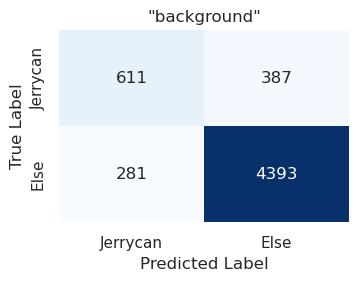

"background"
precsision: 68.50
recall: 61.22
f1: 64.66


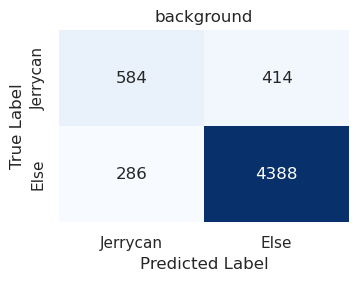

background
precsision: 67.13
recall: 58.52
f1: 62.53


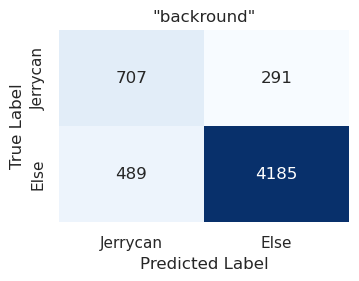

"backround"
precsision: 59.11
recall: 70.84
f1: 64.45


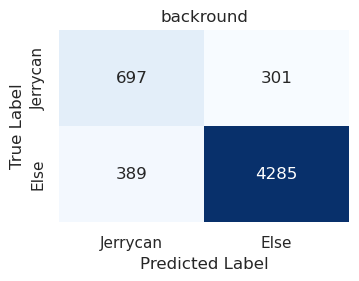

backround
precsision: 64.18
recall: 69.84
f1: 66.89


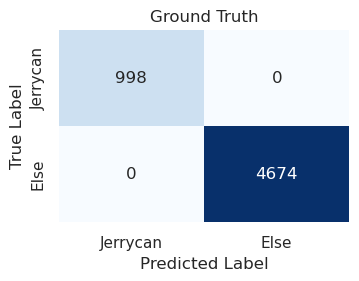

In [18]:
from sklearn.metrics import confusion_matrix

for description in ['background','backround']:
    for focus in ['"','']:
        # load previously build csv
        path_file_embedding_merged = join(path_dir_PromptEngineering,f'{focus}{description}{focus}','embeddings.csv')
        path_file_embeddingsGT = join(path_dir_PromptEngineering,f'{focus}{description}{focus}','embeddingsGT.csv')
        
        df_emb = pd.read_csv(path_file_embedding_merged)
        df_embGT = pd.read_csv(path_file_embedding_merged)
        
        # compute confusion score
        [tp,fp,fn,tn] = getTPxFPxFNxTN(df_emb['jerry_GT'],df_emb['jerry_clip'])
        cm = np.array([[tp,fn],[fp,tn]])
    
        # Define class labels
        class_labels = ['Jerrycan', 'Else']

        # Plot the confusion matrix
        plt.figure(figsize=(1.5*p/2, p/2))
        sns.set(font_scale=1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=class_labels, yticklabels=class_labels)

        plt.title(f'{focus}{description}{focus}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig(join(path_dir_PromptEngineering,f'{focus}{description}{focus}',f'{focus}{description}{focus}.png'), bbox_inches='tight')
        plt.show()
        
        print(f'{focus}{description}{focus}\nprecsision: {100*tp/(fp+tp):.2f}\nrecall: {100*tp/(tp+fn):.2f}\nf1: {100*2*tp/(2*tp+fp+fn):.2f}')
        
[tp,fp,fn,tn] = getTPxFPxFNxTN(df_emb['jerry_GT'],df_emb['jerry_GT'])
cm = np.array([[tp,fn],[fp,tn]])

# Define class labels
class_labels = ['Jerrycan', 'Else']

# Plot the confusion matrix
plt.figure(figsize=(1.5*p/2, p/2))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)

plt.title(f'Ground Truth')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(join(path_dir_PromptEngineering,f'cf_GT.png'), bbox_inches='tight')
plt.show()

#### mAP

##### create json file out of df 

In [13]:
# Preparation of a annotation json file to compute mAP
# ==> filter using jerry_clip and create new json file with score, category_id, and image_id

if False:
    for description in ['background','backround']:
        for focus in ['"','']:
            print(f'{focus}{description}{focus}')
            
            #**************************** SA masks of test set *******************************************
            
            # load df
            prompt_directory = join(path_dir_PromptEngineering,f'{focus}{description}{focus}')
            path_file_embedding_merged = join(prompt_directory,'embeddings.csv')
            df = pd.read_csv(path_file_embedding_merged)
            
            # get jerrycan rows
            is_a_jerrycan_rows = df[df['jerry_clip']==1].index.values
            df_is_a_jerrycan = df.loc[is_a_jerrycan_rows]
            
            # set output path for json file
            path_file_clip_anns = join(prompt_directory,'clip_anns.json')
            
            anns = []
            for image_name in df['image_name'].unique():
                # get annotation_id ans score
                ann_ids = df_is_a_jerrycan[df_is_a_jerrycan['image_name']==image_name]['SA_ann_id'].values
                ann_clip_score = df_is_a_jerrycan[df_is_a_jerrycan['image_name']==image_name]['jerry_clip_score'].values
                
                # load annotations from SA and filter them
                path_file_SA_masks = [p for p in path_list_SA_masks if image_name.split('.')[0] in p][0]
                loc_anns = filterAnnotationFile(path_file_SA_masks,ann_ids)
                
                # add required fields to perform mAP eval
                if len(loc_ann)>0:
                    for ann,score in zip(loc_anns,ann_clip_score):
                        ann['score'] = float(score)
                        ann['image_id'] = int(image_name.split('.')[0])
                        ann['category_id'] = 1
                        anns.append(ann)
                    
            anns = encodeMasks(anns)
            writeJson(path_file_clip_anns,anns)
            
            
            #******************************** GT **********************************************
            # load df
            path_file_embeddingsGT = join(prompt_directory,'embeddingsGT.csv')
            df = pd.read_csv(path_file_embeddingsGT)
            
            # get jerrycan_rows
            is_a_jerrycan_rows = df[df['jerry_clip']==1].index.values
            df_is_a_jerrycan = df.loc[is_a_jerrycan_rows]
            
            # set output path for json file
            path_file_clip_annsGT = join(prompt_directory,'clip_annsGT.json')
            
            anns = []
            for image_name in df['image_name'].unique():
                # get annotation_id ans score
                ann_ids = df_is_a_jerrycan[df_is_a_jerrycan['image_name']==image_name]['global_id'].values
                ann_clip_score = df_is_a_jerrycan[df_is_a_jerrycan['image_name']==image_name]['jerry_clip_score'].values
                
                # filter annotations
                loc_anns = [ann for ann in GT_anns if ann['id'] in ann_ids]
                
                if len(loc_anns)>0:
                    for ann,score in zip(loc_anns,ann_clip_score):
                        ann['score'] = float(score)
                        ann['image_id'] = int(image_name.split('.')[0])
                        ann['category_id'] = 1
                        anns.append(ann)
                        
            anns = encodeMasks(anns)
            writeJson(path_file_clip_annsGT,anns)    

##### eval SA masks {automatically generated on test set}

In [ ]:
columns_AP = ['mAP','AP50','AP75','APs','APm','APl']
columns_AR = ['AR1','AR10','AR100','ARs','ARm','ARl']

to_df = []
for description in ['background','backround']:
    for focus in ['"','']:
        eval_method = f'{focus}{description}{focus}'
        print(eval_method)
        
        prompt_directory = join(path_dir_PromptEngineering,f'{focus}{description}{focus}')
        path_file_clip_anns = join(prompt_directory,'clip_anns.json')
        path_file_results = join(path_dir_PromptEngineering,'mAP.csv')
        
        coco_gt = coco.COCO(json_path_GT_te)
        coco_dt = coco_gt.loadRes(path_file_clip_anns)
        
        coco_eval = cocoeval.COCOeval(coco_gt,coco_dt,'bbox')
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        results_bbox = coco_eval.stats
        to_df.append([eval_method,'bbox']+[100*i for i in results_bbox])
        
        coco_eval = cocoeval.COCOeval(coco_gt,coco_dt,'segm')
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        results_bbox = coco_eval.stats
        to_df.append([eval_method,'segm']+[100*i for i in results_bbox])
        
columns = ['eval_method', 'eval']+columns_AP+columns_AR
df_ap = pd.DataFrame(to_df,columns=columns)
df_ap.to_csv(path_file_results, index=False)

In [15]:
df_ap.sort_values(['eval','mAP'],ascending=[True,False])

,eval_method,eval,mAP,AP50,AP75,APs,APm,APl,AR1,AR10,AR100,ARs,ARm,ARl
4,"""backround""",bbox,52.363623,58.707861,52.344708,-100.0,2.464642,56.922491,4.579624,33.442136,68.753709,-100.0,8.372093,74.367568
6,backround,bbox,51.841698,58.003721,51.884514,-100.0,3.010335,56.336999,4.589515,33.283877,67.833828,-100.0,7.325581,73.459459
0,"""background""",bbox,45.133956,51.773077,45.169475,-100.0,1.554455,49.113594,4.203759,31.790307,59.752720,-100.0,2.325581,65.091892
2,background,bbox,43.154818,49.478936,42.922039,-100.0,0.534653,47.130838,4.371909,31.503462,57.171118,-100.0,1.162791,62.378378
5,"""backround""",segm,55.032497,60.074877,54.475819,-100.0,2.504756,59.536927,4.599407,34.490603,70.474777,-100.0,9.186047,76.172973
7,backround,segm,54.583901,59.993447,54.012983,-100.0,3.078413,59.321649,4.599407,34.203759,69.584570,-100.0,7.558140,75.351351
1,"""background""",segm,47.539691,52.609188,46.930901,-100.0,1.386139,51.771024,4.381800,32.898121,61.335312,-100.0,2.209302,66.832432
3,background,segm,45.693869,51.777900,44.752543,-100.0,0.722772,49.799029,4.460930,32.373887,58.911968,-100.0,1.511628,64.248649


##### eval SA masks {human-in-the-loop prompts on test set} 

In [ ]:
columns_AP = ['mAP','AP50','AP75','APs','APm','APl']
columns_AR = ['AR1','AR10','AR100','ARs','ARm','ARl']

to_df = []
for description in ['background','backround']:
    for focus in ['"','']:
        eval_method = f'{focus}{description}{focus}'
        print(eval_method)
        
        prompt_directory = join(path_dir_PromptEngineering,f'{focus}{description}{focus}')
        path_file_clip_anns = join(prompt_directory,'clip_annsGT.json')
        path_file_results = join(path_dir_PromptEngineering,'mAP_GT.csv')
        
        coco_gt = coco.COCO(json_path_GT_te)
        coco_dt = coco_gt.loadRes(path_file_clip_anns)
        
        coco_eval = cocoeval.COCOeval(coco_gt,coco_dt,'bbox')
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        results_bbox = coco_eval.stats
        to_df.append([eval_method,'bbox']+[100*i for i in results_bbox])
        
        coco_eval = cocoeval.COCOeval(coco_gt,coco_dt,'segm')
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        results_bbox = coco_eval.stats
        to_df.append([eval_method,'segm']+[100*i for i in results_bbox])
        
columns = ['eval_method', 'eval']+columns_AP+columns_AR
df_ap = pd.DataFrame(to_df,columns=columns)
df_ap.to_csv(path_file_results, index=False)

In [17]:
df_ap.sort_values(['eval','mAP'],ascending=[True,False]).iloc[:,:8]

,eval_method,eval,mAP,AP50,AP75,APs,APm,APl
6,backround,bbox,70.244483,70.244483,70.244483,-100.0,6.930693,76.180449
4,"""backround""",bbox,69.246798,69.246798,69.246798,-100.0,9.900990,75.181047
0,"""background""",bbox,59.361754,59.361754,59.361754,-100.0,2.970297,65.297276
2,background,bbox,57.386344,57.386344,57.386344,-100.0,1.980198,62.333339
7,backround,segm,70.244483,70.244483,70.244483,-100.0,6.930693,76.180449
5,"""backround""",segm,69.246798,69.246798,69.246798,-100.0,9.900990,75.181047
1,"""background""",segm,59.361754,59.361754,59.361754,-100.0,2.970297,65.297276
3,background,segm,57.386344,57.386344,57.386344,-100.0,1.980198,62.333339


**==> "backround" works better on test set, whereas backround works better on GT"**
* Select "backround" because closer to reality 

**==> GT misclassification level reaches *at least* 30%**
* Where does the rest go ? 

### Best prompt structure: quick look at classification distribution 

In [20]:
# generate basic categories using best prompt structure
categories = [
    f'part of a "{o}" on a black backround' 
    for j in range(len(objects)) 
    for o in objects[j]]

categories += ['it is not clear what the picture shows']
[print(i) for i in categories]

# generate category dictionnary
dico_cat = {}
items = [o for sublist in objects for o in sublist]
for idx, item in enumerate(items):
    dico_cat[idx] = item
    
dico_cat[len(categories)-1]='unclear'
dico_cat

part of a "beam" on a black backround
part of a "wall" on a black backround
part of a "structural element" on a black backround
part of a "pipe (fluid conveyance)" on a black backround
part of a "bottle" on a black backround
part of a "cap" on a black backround
part of a "jerrycan" on a black backround
part of a "label" on a black backround
part of a "sticker" on a black backround
it is not clear what the picture shows


{0: 'beam',
 1: 'wall',
 2: 'structural element',
 3: 'pipe (fluid conveyance)',
 4: 'bottle',
 5: 'cap',
 6: 'jerrycan',
 7: 'label',
 8: 'sticker',
 9: 'unclear'}

In [21]:
# load corresponding dfs
prompt_directory = join(path_dir_PromptEngineering,'"backround"')
print(prompt_directory)

path_file_embeddings = join(prompt_directory,'embeddings.csv')
path_file_embeddings = join(prompt_directory,'embeddings.csv')

df_emb = pd.read_csv(path_file_embeddings)
df_embGT = pd.read_csv(path_file_embeddings)

/home/dkhatanassia/PDM/01_Development/mAP_SA_CLIP/01_PromptEngineering/"backround"


In [24]:
# print distribution
all_ratios = df_emb['cat'].value_counts(normalize=True)*100
[print(f'{ratio:.2f}%: {dico_cat[idx]}') for ratio, idx in zip(all_ratios.values,all_ratios.index)]

27.20%: pipe (fluid conveyance)
21.09%: jerrycan
10.97%: beam
9.68%: unclear
8.80%: bottle
7.92%: cap
6.77%: label
3.68%: structural element
2.61%: wall
1.29%: sticker


[None, None, None, None, None, None, None, None, None, None]

**==> based on distribution, there are more pipes than jerrycans!**

**==> without surprise, label works better than sticker**

**==> we don't perform further stat since we don't have labels except for jerrycans**

## CLIPxSA: categories finetuning

In [234]:
#'supercategory':'fg',
#'id':1,
#'name':'fg'

# HDPE ==>                                      # https://en.wikipedia.org/wiki/High-density_polyethylene

#        'Caged IBC tote': 3                    # https://en.wikipedia.org/wiki/Caged_IBC_tote
#        'cistern': 4                           # https://en.wikipedia.org/wiki/Cistern#/media/File:Kunststoffzisterne_IMG_20170714_120822174.jpg   
#        'waste container': 5                    # https://en.wikipedia.org/wiki/Waste_container#English
#        'monobloc chair': 1,                    # https://en.wikipedia.org/wiki/Monobloc_(chair)


supercategories = {
    1: 'liquid container',
    2: 'pipe',
    3: 'carrying solution',
    4: 'subparts',
    5: 'background'
}

categories = {
    1: {
        'jerrycan': 1,                          # https://en.wikipedia.org/wiki/Jerrycan
        'drum': 2,                              # https://en.wikipedia.org/wiki/Drum_(container)
        'bucket': 3,                            # https://en.wikipedia.org/wiki/Bucket
        'PET bottle': 4,                        # https://en.wikipedia.org/wiki/Bottle
        'shampoo bottle': 5                     # https://en.wikipedia.org/wiki/Bottle
    },
    
    2: {
        'HDPE pipe':1,                          # https://en.wikipedia.org/wiki/HDPE_pipe
        'plastic tubing':2                      # https://en.wikipedia.org/wiki/Tube_(fluid_conveyance)
    },
    
    3: {
        'plastic pallet': 1,                    # https://en.wikipedia.org/wiki/Pallet#Plastic_pallet
        'bottle crate': 2,                      # https://en.wikipedia.org/wiki/Bottle_crate
    },
    
    4: {
        'bottle cap': 1,                        # https://en.wikipedia.org/wiki/Bottle_cap
        'label': 2                              # https://en.wikipedia.org/wiki/Label
    },
    
    5: {
        'wall':1,                               # https://en.wikipedia.org/wiki/Wall
        'extruded aluminium profile':2,         # https://en.wikipedia.org/wiki/Extrusion
        'structural element': 3
    }
}

categories10 = {
    1: {
        'jerrycan': 1,                          # https://en.wikipedia.org/wiki/Jerrycan
        'drum': 2,                              # https://en.wikipedia.org/wiki/Drum_(container)
        'bucket': 3,                            # https://en.wikipedia.org/wiki/Bucket
#        'PET bottle': 4,                        # https://en.wikipedia.org/wiki/Bottle
        'shampoo bottle': 5                     # https://en.wikipedia.org/wiki/Bottle
    },
    
    2: {
        'HDPE pipe':1,                          # https://en.wikipedia.org/wiki/HDPE_pipe
#       'plastic tubing':2                      # https://en.wikipedia.org/wiki/Tube_(fluid_conveyance)
    },
    
    3: {
#        'plastic pallet': 1,                    # https://en.wikipedia.org/wiki/Pallet#Plastic_pallet
#        'bottle crate': 2,                      # https://en.wikipedia.org/wiki/Bottle_crate
    },
    
    4: {
#        'bottle cap': 1,                        # https://en.wikipedia.org/wiki/Bottle_cap
        'label': 2                              # https://en.wikipedia.org/wiki/Label
    },
    
    5: {
        'wall':1,                               # https://en.wikipedia.org/wiki/Wall
        'extruded aluminium profile':2,         # https://en.wikipedia.org/wiki/Extrusion
        'structural element': 3
    }
}

description = {
    1: f'a kind of {supercategories[1]}, ',
    2: f'a kind of {supercategories[2]}, ',
    3: f'a kind of {supercategories[3]}, ',
    4: '',
    5: '',
}

text_prompt_categories = []
for sc in supercategories:
    for c in categories[sc]:
        text_prompt_categories.append(
            f'part of a "{c}" seen from above on a black backround'
            )
text_prompt_categories.append('it is not clear what the image shows')
        
print(len(text_prompt_categories))
text_prompt_categories

# classic10 f'part of a "{c}" on a black backround' with {11,12,12,15,21,42,51,52,53,not_clear}
# classic: f'part of a "{c}" on a black backround'
# description: f'part of a "{c}", {description[sc]}on a black backround'
# occluded: f'a partially occluded "{c}" on a black backround'
# seen from above: f'part of a "{c}" seen from above on a black backround'
# description+occluded+seen_from_above: f'A partially occluded "{c}", {description[sc]}seen from above, on a black backround.'

15


['part of a "jerrycan" seen from above on a black backround',
 'part of a "drum" seen from above on a black backround',
 'part of a "bucket" seen from above on a black backround',
 'part of a "PET bottle" seen from above on a black backround',
 'part of a "shampoo bottle" seen from above on a black backround',
 'part of a "HDPE pipe" seen from above on a black backround',
 'part of a "plastic tubing" seen from above on a black backround',
 'part of a "plastic pallet" seen from above on a black backround',
 'part of a "bottle crate" seen from above on a black backround',
 'part of a "bottle cap" seen from above on a black backround',
 'part of a "label" seen from above on a black backround',
 'part of a "wall" seen from above on a black backround',
 'part of a "extruded aluminium profile" seen from above on a black backround',
 'part of a "structural element" seen from above on a black backround',
 'it is not clear what the image shows']

In [242]:
methods = ['classic10', 'classic','description','occluded','above']
text_prompt_categories = [
    [f'part of a "{c}", on a black background'                       for sc in range(1,len(supercategories)+1) for c in categories10[sc]]+['it is not clear what the image shows'],
    [f'part of a "{c}", on a black background'                       for sc in range(1,len(supercategories)+1) for c in categories[sc]]+['it is not clear what the image shows'],
    [f'part of a "{c}", {description[sc]}on a black background'     for sc in range(1,len(supercategories)+1) for c in categories[sc]]+['it is not clear what the image shows'],
    [f'a partially occluded "{c}", on a black background'            for sc in range(1,len(supercategories)+1) for c in categories[sc]]+['it is not clear what the image shows'],
    [f'part of a "{c}", seen from above on a black background'      for sc in range(1,len(supercategories)+1) for c in categories[sc]]+['it is not clear what the image shows']
    ]

part of a "jerrycan", on a black background
part of a "drum", on a black background
part of a "bucket", on a black background
part of a "shampoo bottle", on a black background
part of a "HDPE pipe", on a black background
part of a "label", on a black background
part of a "wall", on a black background
part of a "extruded aluminium profile", on a black background
part of a "structural element", on a black background
it is not clear what the image shows


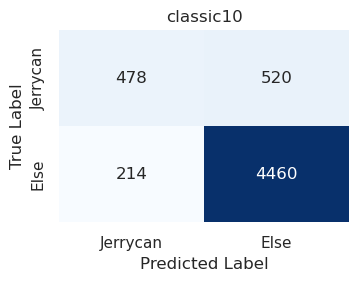

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.358
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.398
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

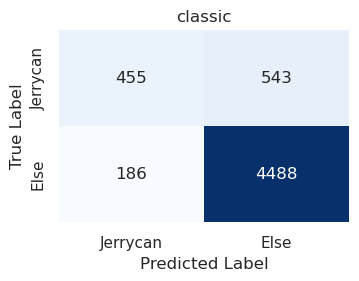

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.386
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.044
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

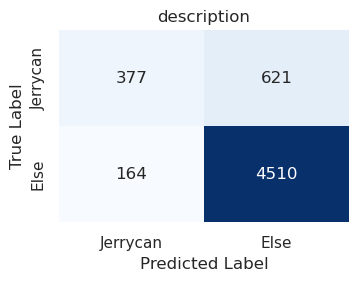

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.045
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.278
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

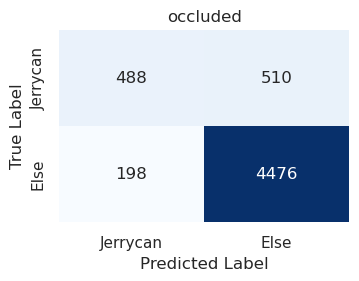

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.433
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.409
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.045
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

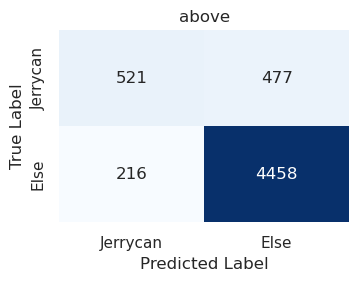

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.432
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.045
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [243]:
dir = 'better_taxonomy'
for eval_method, text_prompt in zip(methods,text_prompt_categories):
    directory = join(dir,eval_method)

    [print(tpi) for tpi in text_prompt]

    # set output location
    path_dir_embeddings = join(path_dir_PromptEngineering, directory, 'embeddings')
    os.makedirs(path_dir_embeddings)
    
    #**************************** SA masks of test set **********************************************
    for image_path, masks_path in zip(path_list_images_GT, path_list_SA_masks_GT):
        # name of file to store embedding
        image_name = image_path.split('/')[-1]
        path_file_embedding = join(path_dir_embeddings,image_name.split('.')[0]+'.csv')
        
        # load image
        image = cv2.imread(image_path)
        
        # get decoded masks
        masks = decodeMasks(readJson(masks_path))
        
        # init container
        to_df = []
        
        # get all embeddings
        for idx,item in enumerate(masks):
            # add columns to link with SA annotation
            columns = ['image_name','SA_ann_id']
            row = [image_name, idx]
            
            # crop mask
            offset = 10
            cropped = cropMask(image,item,offset)
            
            # save size
            h,w = cropped[:,:,0].shape
            columns += ['height','width']
            row += [h-2*offset,w-2*offset]
            
            # save cat, score
            score, cat, _ = computeScore(cropped,text_prompt,clp)
            
            columns += ['cat','score']
            row += [cat, score]
            
            # add to container
            to_df.append(row)
            
        # create df and save it 
        df = pd.DataFrame(to_df,columns=columns)
        df.to_csv(path_file_embedding, index=False)
        
    # merge all image-wise csv
    path_file_embedding_merged = join(path_dir_PromptEngineering,directory,'embeddings.csv')
    path_list_embeddings = sorted(collectFiles([path_dir_embeddings]))
    df_emb = buildDf(path_list_embeddings)
    df_emb.to_csv(path_file_embedding_merged, index=False)
    
    #****************************************** GT ****************************************************************
    GT_anns = decodeMasks(readJson(json_path_GT_te)['annotations'])    
    path_file_embeddingsGT = join(path_dir_PromptEngineering,directory,'embeddingsGT.csv')
    
    to_df = []
    for image_name in GT_names:
        image_path = [p for p in path_list_images_GT if image_name in p][0]
        image=cv2.imread(image_path)
        
        image_id = int(image_name.split('.')[0])
        related_anns = [ann for ann in GT_anns if ann['image_id']==image_id]

        for idx,item in enumerate(related_anns):
            columns =  ['image_name','global_id','local_id']
            row = [image_name, item['id'], idx]
            
            # crop mask
            offset = 10
            cropped = cropMask(image,item,offset)
            
            # save size
            h,w = cropped[:,:,0].shape
            columns += ['height','width']
            row += [h-2*offset,w-2*offset]
            
            # save embedding
            score, cat, _ = computeScore(cropped,text_prompt,clp)
            columns += ['cat','score']
            row += [cat, score]
            
            to_df.append(row)
            
    df = pd.DataFrame(to_df,columns=columns)
    df.to_csv(path_file_embeddingsGT, index=False)
    
    
# add binary array: 1 if annotation in GT else 0
# add score column: jerry_score if cat == jerrycan else 0
# add binary array: 1 if cat == jerrycan else 0

# ==> used to compute mAP and confusion matrices.

    looking_for = 'jerrycan'
    cat_id = text_prompt.index([tpi for tpi in text_prompt if looking_for in tpi][0])
    
    path_file_embedding_merged = join(path_dir_PromptEngineering,directory,'embeddings.csv')
    path_file_embeddingsGT = join(path_dir_PromptEngineering,directory,'embeddingsGT.csv')
    
    df_emb = pd.read_csv(path_file_embedding_merged)
    df_embGT = pd.read_csv(path_file_embeddingsGT)
    
    mask_in_GT = df_emb.apply(lambda row: 1 if row['SA_ann_id'] in (df_match[df_match['image_name']==row['image_name']]['SA_ann_id'].values) else 0, axis=1).values

    df_emb.insert(0,'jerry_GT',mask_in_GT)
    df_emb.insert(0, 'jerry_clip_score', list(df_emb.apply(lambda row: 0 if row['cat'] != cat_id else row['score'], axis=1).values))
    df_emb.insert(0, 'jerry_clip', list((df_emb['cat']==cat_id).values.astype(int)))
    df_emb.to_csv(path_file_embedding_merged,index=False)
    
    
    df_embGT = pd.read_csv(path_file_embeddingsGT)
    df_embGT.insert(0, 'jerry_clip_score', list(df_embGT.apply(lambda row: 0 if row['cat'] != cat_id else row['score'], axis=1).values))
    df_embGT.insert(0, 'jerry_clip', list((df_embGT['cat']==cat_id).values.astype(int)))
    df_embGT.to_csv(path_file_embeddingsGT,index=False)
    
# Confusion matrix
    # load previously build csv
    path_file_embedding_merged = join(path_dir_PromptEngineering,directory,'embeddings.csv')
    path_file_embeddingsGT = join(path_dir_PromptEngineering,directory,'embeddingsGT.csv')

    df_emb = pd.read_csv(path_file_embedding_merged)
    df_embGT = pd.read_csv(path_file_embeddingsGT)

    # compute confusion score
    [tp,fp,fn,tn] = getTPxFPxFNxTN(df_emb['jerry_GT'],df_emb['jerry_clip'])
    cm = np.array([[tp,fn],[fp,tn]])

    # Define class labels
    class_labels = ['Jerrycan', 'Else']

    # Plot the confusion matrix
    plt.figure(figsize=(1.5*p/2, p/2))
    sns.set(font_scale=1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)

    plt.title(f'{eval_method}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(join(path_dir_PromptEngineering, dir ,f'{eval_method}.png'), bbox_inches='tight')
    plt.show()
    
# Preparation of a annotation json file to compute mAP
# ==> filter using jerry_clip and create new json file with score, category_id, and image_id

            
    #**************************** SA masks of test set *******************************************
    
    # load df
    prompt_directory = join(path_dir_PromptEngineering,directory)
    path_file_embedding_merged = join(prompt_directory,'embeddings.csv')
    df = pd.read_csv(path_file_embedding_merged)
    
    # get jerrycan rows
    is_a_jerrycan_rows = df[df['jerry_clip']==1].index.values
    df_is_a_jerrycan = df.loc[is_a_jerrycan_rows]
    
    # set output path for json file
    path_file_clip_anns = join(prompt_directory,'clip_anns.json')
    
    anns = []
    for image_name in df['image_name'].unique():
        # get annotation_id ans score
        ann_ids = df_is_a_jerrycan[df_is_a_jerrycan['image_name']==image_name]['SA_ann_id'].values
        ann_clip_score = df_is_a_jerrycan[df_is_a_jerrycan['image_name']==image_name]['jerry_clip_score'].values
        
        # load annotations from SA and filter them
        path_file_SA_masks = [p for p in path_list_SA_masks if image_name.split('.')[0] in p][0]
        loc_anns = filterAnnotationFile(path_file_SA_masks,ann_ids)
        
        # add required fields to perform mAP eval
        if len(loc_anns)>0:
            for ann,score in zip(loc_anns,ann_clip_score):
                ann['score'] = float(score)
                ann['image_id'] = int(image_name.split('.')[0])
                ann['category_id'] = 1
                anns.append(ann)
            
    anns = encodeMasks(anns)
    writeJson(path_file_clip_anns,anns)
    
    
    #******************************** GT **********************************************
    # load df
    path_file_embeddingsGT = join(prompt_directory,'embeddingsGT.csv')
    df = pd.read_csv(path_file_embeddingsGT)
    
    # get jerrycan_rows
    is_a_jerrycan_rows = df[df['jerry_clip']==1].index.values
    df_is_a_jerrycan = df.loc[is_a_jerrycan_rows]
    
    # set output path for json file
    path_file_clip_annsGT = join(prompt_directory,'clip_annsGT.json')
    
    anns = []
    for image_name in df['image_name'].unique():
        # get annotation_id ans score
        ann_ids = df_is_a_jerrycan[df_is_a_jerrycan['image_name']==image_name]['global_id'].values
        ann_clip_score = df_is_a_jerrycan[df_is_a_jerrycan['image_name']==image_name]['jerry_clip_score'].values
        
        # filter annotations
        loc_anns = [ann for ann in GT_anns if ann['id'] in ann_ids]
        
        if len(loc_anns)>0:
            for ann,score in zip(loc_anns,ann_clip_score):
                ann['score'] = float(score)
                ann['image_id'] = int(image_name.split('.')[0])
                ann['category_id'] = 1
                anns.append(ann)
                
    anns = encodeMasks(anns)
    writeJson(path_file_clip_annsGT,anns)    
    




    columns_AP = ['mAP','AP50','AP75','APs','APm','APl']
    columns_AR = ['AR1','AR10','AR100','ARs','ARm','ARl']

    to_df = []

    prompt_directory = join(path_dir_PromptEngineering, directory)
    path_file_clip_anns = join(prompt_directory,'clip_anns.json')
    path_file_results = join(prompt_directory,'mAP.csv')

    coco_gt = coco.COCO(json_path_GT_te)
    coco_dt = coco_gt.loadRes(path_file_clip_anns)

    coco_eval = cocoeval.COCOeval(coco_gt,coco_dt,'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    results_bbox = coco_eval.stats
    to_df.append([eval_method,'bbox']+[100*i for i in results_bbox])

    coco_eval = cocoeval.COCOeval(coco_gt,coco_dt,'segm')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    results_bbox = coco_eval.stats
    to_df.append([eval_method,'segm']+[100*i for i in results_bbox])

    columns = ['eval_method', 'eval']+columns_AP+columns_AR
    df_ap = pd.DataFrame(to_df,columns=columns)
    df_ap.to_csv(path_file_results, index=False)


    columns_AP = ['mAP','AP50','AP75','APs','APm','APl']
    columns_AR = ['AR1','AR10','AR100','ARs','ARm','ARl']

    to_df = []
            
    prompt_directory = join(path_dir_PromptEngineering,directory)
    path_file_clip_anns = join(prompt_directory,'clip_annsGT.json')
    path_file_results = join(prompt_directory,'mAP_GT.csv')

    coco_gt = coco.COCO(json_path_GT_te)
    coco_dt = coco_gt.loadRes(path_file_clip_anns)

    coco_eval = cocoeval.COCOeval(coco_gt,coco_dt,'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    results_bbox = coco_eval.stats
    to_df.append([eval_method,'bbox']+[100*i for i in results_bbox])

    coco_eval = cocoeval.COCOeval(coco_gt,coco_dt,'segm')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    results_bbox = coco_eval.stats
    to_df.append([eval_method,'segm']+[100*i for i in results_bbox])
            
    columns = ['eval_method', 'eval']+columns_AP+columns_AR
    df_ap = pd.DataFrame(to_df,columns=columns)
    df_ap.to_csv(path_file_results, index=False)

In [ ]:
# path_dir_embeddings: folder containing image-wise csv file with columns [image_name, SA_ann_id, height, width, cat, score]
# path_file_embedding: full path to file of image-wise csv
# path_file_embedding_merged: full path to merged csv file
# path_file_embeddingsGT : full path to GT csv file
dir = 'better_taxonomy'
eval_method = 'classic10'

directory = join(dir,eval_method)
categories = text_prompt_categories
if True:
    [print(cat) for cat in categories]
    # set output location
    path_dir_embeddings = join(path_dir_PromptEngineering, directory, 'embeddings')
    os.makedirs(path_dir_embeddings)
    
    #**************************** SA masks of test set **********************************************
    for image_path, masks_path in zip(path_list_images_GT, path_list_SA_masks_GT):
        # name of file to store embedding
        image_name = image_path.split('/')[-1]
        path_file_embedding = join(path_dir_embeddings,image_name.split('.')[0]+'.csv')
        
        # load image
        image = cv2.imread(image_path)
        
        # get decoded masks
        masks = decodeMasks(readJson(masks_path))
        
        # init container
        to_df = []
        
        # get all embeddings
        for idx,item in enumerate(masks):
            # add columns to link with SA annotation
            columns = ['image_name','SA_ann_id']
            row = [image_name, idx]
            
            # crop mask
            offset = 10
            cropped = cropMask(image,item,offset)
            
            # save size
            h,w = cropped[:,:,0].shape
            columns += ['height','width']
            row += [h-2*offset,w-2*offset]
            
            # save cat, score
            score, cat, _ = computeScore(cropped,categories,clp)
            
            columns += ['cat','score']
            row += [cat, score]
            
            # add to container
            to_df.append(row)
            
        # create df and save it 
        df = pd.DataFrame(to_df,columns=columns)
        df.to_csv(path_file_embedding, index=False)
        
    # merge all image-wise csv
    path_file_embedding_merged = join(path_dir_PromptEngineering,directory,'embeddings.csv')
    path_list_embeddings = sorted(collectFiles([path_dir_embeddings]))
    df_emb = buildDf(path_list_embeddings)
    df_emb.to_csv(path_file_embedding_merged, index=False)
    
    #****************************************** GT ****************************************************************
    GT_anns = decodeMasks(readJson(json_path_GT_te)['annotations'])    
    path_file_embeddingsGT = join(path_dir_PromptEngineering,directory,'embeddingsGT.csv')
    
    to_df = []
    for image_name in GT_names:
        image_path = [p for p in path_list_images_GT if image_name in p][0]
        image=cv2.imread(image_path)
        
        image_id = int(image_name.split('.')[0])
        related_anns = [ann for ann in GT_anns if ann['image_id']==image_id]

        for idx,item in enumerate(related_anns):
            columns =  ['image_name','global_id','local_id']
            row = [image_name, item['id'], idx]
            
            # crop mask
            offset = 10
            cropped = cropMask(image,item,offset)
            
            # save size
            h,w = cropped[:,:,0].shape
            columns += ['height','width']
            row += [h-2*offset,w-2*offset]
            
            # save embedding
            score, cat, _ = computeScore(cropped,categories,clp)
            columns += ['cat','score']
            row += [cat, score]
            
            to_df.append(row)
            
    df = pd.DataFrame(to_df,columns=columns)
    df.to_csv(path_file_embeddingsGT, index=False)

In [147]:
# add binary array: 1 if annotation in GT else 0
# add score column: jerry_score if cat == jerrycan else 0
# add binary array: 1 if cat == jerrycan else 0

# ==> used to compute mAP and confusion matrices.
if True:
    looking_for = 'jerrycan'
    cat_id = categories.index([c for c in categories if looking_for in c][0])
    
    path_file_embedding_merged = join(path_dir_PromptEngineering,directory,'embeddings.csv')
    path_file_embeddingsGT = join(path_dir_PromptEngineering,directory,'embeddingsGT.csv')
    
    df_emb = pd.read_csv(path_file_embedding_merged)
    df_embGT = pd.read_csv(path_file_embeddingsGT)
    
    mask_in_GT = df_emb.apply(lambda row: 1 if row['SA_ann_id'] in (df_match[df_match['image_name']==row['image_name']]['SA_ann_id'].values) else 0, axis=1).values

    df_emb.insert(0,'jerry_GT',mask_in_GT)
    df_emb.insert(0, 'jerry_clip_score', list(df_emb.apply(lambda row: 0 if row['cat'] != cat_id else row['score'], axis=1).values))
    df_emb.insert(0, 'jerry_clip', list((df_emb['cat']==cat_id).values.astype(int)))
    df_emb.to_csv(path_file_embedding_merged,index=False)
    
    
    df_embGT = pd.read_csv(path_file_embeddingsGT)
    df_embGT.insert(0, 'jerry_clip_score', list(df_embGT.apply(lambda row: 0 if row['cat'] != cat_id else row['score'], axis=1).values))
    df_embGT.insert(0, 'jerry_clip', list((df_embGT['cat']==cat_id).values.astype(int)))
    df_embGT.to_csv(path_file_embeddingsGT,index=False)

#### Confusion matrix

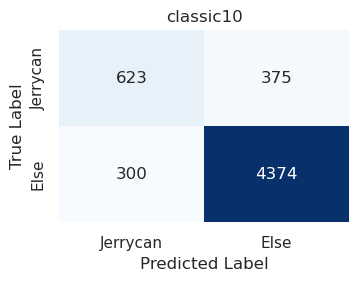

In [150]:
# load previously build csv
path_file_embedding_merged = join(path_dir_PromptEngineering,directory,'embeddings.csv')
path_file_embeddingsGT = join(path_dir_PromptEngineering,directory,'embeddingsGT.csv')

df_emb = pd.read_csv(path_file_embedding_merged)
df_embGT = pd.read_csv(path_file_embeddingsGT)

# compute confusion score
[tp,fp,fn,tn] = getTPxFPxFNxTN(df_emb['jerry_GT'],df_emb['jerry_clip'])
cm = np.array([[tp,fn],[fp,tn]])

# Define class labels
class_labels = ['Jerrycan', 'Else']

# Plot the confusion matrix
plt.figure(figsize=(1.5*p/2, p/2))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)

plt.title(f'{eval_method}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(join(path_dir_PromptEngineering,dir,f'{eval_method}.png'), bbox_inches='tight')
plt.show()

#### mAP

##### create json file out of df 

In [151]:
# Preparation of a annotation json file to compute mAP
# ==> filter using jerry_clip and create new json file with score, category_id, and image_id

if True:
            
    #**************************** SA masks of test set *******************************************
    
    # load df
    prompt_directory = join(path_dir_PromptEngineering,directory)
    path_file_embedding_merged = join(prompt_directory,'embeddings.csv')
    df = pd.read_csv(path_file_embedding_merged)
    
    # get jerrycan rows
    is_a_jerrycan_rows = df[df['jerry_clip']==1].index.values
    df_is_a_jerrycan = df.loc[is_a_jerrycan_rows]
    
    # set output path for json file
    path_file_clip_anns = join(prompt_directory,'clip_anns.json')
    
    anns = []
    for image_name in df['image_name'].unique():
        # get annotation_id ans score
        ann_ids = df_is_a_jerrycan[df_is_a_jerrycan['image_name']==image_name]['SA_ann_id'].values
        ann_clip_score = df_is_a_jerrycan[df_is_a_jerrycan['image_name']==image_name]['jerry_clip_score'].values
        
        # load annotations from SA and filter them
        path_file_SA_masks = [p for p in path_list_SA_masks if image_name.split('.')[0] in p][0]
        loc_anns = filterAnnotationFile(path_file_SA_masks,ann_ids)
        
        # add required fields to perform mAP eval
        if len(loc_anns)>0:
            for ann,score in zip(loc_anns,ann_clip_score):
                ann['score'] = float(score)
                ann['image_id'] = int(image_name.split('.')[0])
                ann['category_id'] = 1
                anns.append(ann)
            
    anns = encodeMasks(anns)
    writeJson(path_file_clip_anns,anns)
    
    
    #******************************** GT **********************************************
    # load df
    path_file_embeddingsGT = join(prompt_directory,'embeddingsGT.csv')
    df = pd.read_csv(path_file_embeddingsGT)
    
    # get jerrycan_rows
    is_a_jerrycan_rows = df[df['jerry_clip']==1].index.values
    df_is_a_jerrycan = df.loc[is_a_jerrycan_rows]
    
    # set output path for json file
    path_file_clip_annsGT = join(prompt_directory,'clip_annsGT.json')
    
    anns = []
    for image_name in df['image_name'].unique():
        # get annotation_id ans score
        ann_ids = df_is_a_jerrycan[df_is_a_jerrycan['image_name']==image_name]['global_id'].values
        ann_clip_score = df_is_a_jerrycan[df_is_a_jerrycan['image_name']==image_name]['jerry_clip_score'].values
        
        # filter annotations
        loc_anns = [ann for ann in GT_anns if ann['id'] in ann_ids]
        
        if len(loc_anns)>0:
            for ann,score in zip(loc_anns,ann_clip_score):
                ann['score'] = float(score)
                ann['image_id'] = int(image_name.split('.')[0])
                ann['category_id'] = 1
                anns.append(ann)
                
    anns = encodeMasks(anns)
    writeJson(path_file_clip_annsGT,anns)    

##### eval SA masks {automatically generated on test set}

In [152]:
columns_AP = ['mAP','AP50','AP75','APs','APm','APl']
columns_AR = ['AR1','AR10','AR100','ARs','ARm','ARl']

to_df = []

prompt_directory = join(path_dir_PromptEngineering, directory)
path_file_clip_anns = join(prompt_directory,'clip_anns.json')
path_file_results = join(prompt_directory,'mAP.csv')

coco_gt = coco.COCO(json_path_GT_te)
coco_dt = coco_gt.loadRes(path_file_clip_anns)

coco_eval = cocoeval.COCOeval(coco_gt,coco_dt,'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()
results_bbox = coco_eval.stats
to_df.append([eval_method,'bbox']+[100*i for i in results_bbox])

coco_eval = cocoeval.COCOeval(coco_gt,coco_dt,'segm')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()
results_bbox = coco_eval.stats
to_df.append([eval_method,'segm']+[100*i for i in results_bbox])

columns = ['eval_method', 'eval']+columns_AP+columns_AR
df_ap = pd.DataFrame(to_df,columns=columns)
df_ap.to_csv(path_file_results, index=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.508
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.045
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [153]:
df_ap.sort_values(['eval','mAP'],ascending=[True,False])

,eval_method,eval,mAP,AP50,AP75,APs,APm,APl,AR1,AR10,AR100,ARs,ARm,ARl
0,classic10,bbox,46.662224,53.479383,45.830216,-100.0,0.870462,50.829786,4.520277,33.184965,60.791296,-100.0,3.488372,66.118919
1,classic10,segm,49.132569,54.975978,48.606666,-100.0,0.942657,53.486431,4.609298,33.946588,62.423343,-100.0,3.604651,67.891892


##### eval SA masks {human-in-the-loop prompts on test set} 

In [154]:
columns_AP = ['mAP','AP50','AP75','APs','APm','APl']
columns_AR = ['AR1','AR10','AR100','ARs','ARm','ARl']

to_df = []
        
prompt_directory = join(path_dir_PromptEngineering,directory)
path_file_clip_anns = join(prompt_directory,'clip_annsGT.json')
path_file_results = join(prompt_directory,'mAP_GT.csv')

coco_gt = coco.COCO(json_path_GT_te)
coco_dt = coco_gt.loadRes(path_file_clip_anns)

coco_eval = cocoeval.COCOeval(coco_gt,coco_dt,'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()
results_bbox = coco_eval.stats
to_df.append([eval_method,'bbox']+[100*i for i in results_bbox])

coco_eval = cocoeval.COCOeval(coco_gt,coco_dt,'segm')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()
results_bbox = coco_eval.stats
to_df.append([eval_method,'segm']+[100*i for i in results_bbox])
        
columns = ['eval_method', 'eval']+columns_AP+columns_AR
df_ap = pd.DataFrame(to_df,columns=columns)
df_ap.to_csv(path_file_results, index=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.623
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.623
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.623
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.683
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [155]:
df_ap.sort_values(['eval','mAP'],ascending=[True,False]).iloc[:,:8]

,eval_method,eval,mAP,AP50,AP75,APs,APm,APl
0,classic10,bbox,62.31984,62.31984,62.31984,-100.0,2.970297,68.253968
1,classic10,segm,62.31984,62.31984,62.31984,-100.0,2.970297,68.253968
